In [2]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import os
import tensorflow as tf
import pandas as pd
np.set_printoptions(linewidth=500,precision=2,suppress=True)
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable


from IPython.display import clear_output

vmin=1e-4


In [3]:
def data_reading(image_file):
    output_list=pyfits.open(image_file)
    image = output_list[1]
    image_data=image.data[0,0,:,:]
    
    image_data[np.isnan(image_data)]=0.
    image_data[np.where(image_data<=0.)]=vmin
    vmax=image_data.max()
    image_data = np.flipud(image_data)
    
    image_data = np.log10(np.clip(image_data, vmin, vmax))
    
    
    return image_data


In [4]:
#Dat from Freundlich J., et al., 2019, , 622, A105
image_files = ("PHIBSS2/xg53.fits", 
               "PHIBSS2/xi53.fits",
               "PHIBSS2/xn53.fits",
               "PHIBSS2/l14eg010.fits",
               "PHIBSS2/l14eg015.fits",
               "PHIBSS2/l14gn007.fits",
               "PHIBSS2/l14gn032.fits")

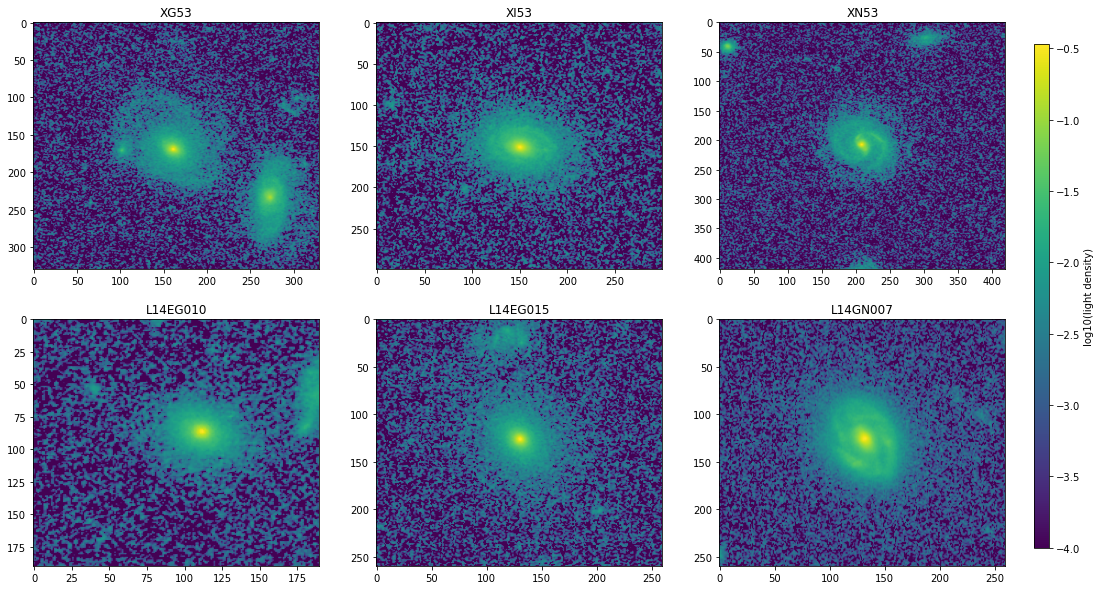

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

gnames=['XG53', 'XI53', 'XN53', 'L14EG010', 'L14EG015', 'L14GN007', 'L14GN032' ]

a=0
for i in range(2): 
    for j in range(3):
        data = data_reading(image_files[a])
        im = ax[i][j].imshow(data, aspect = 'auto')
        ax[i][j].set_title(r'%s' %gnames[a])
        a=a+1
        #plt.colorbar(im, ax=ax[i, j])
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax, label='log10(light density)')

#plt.savefig('HST_data.png', dpi=100)

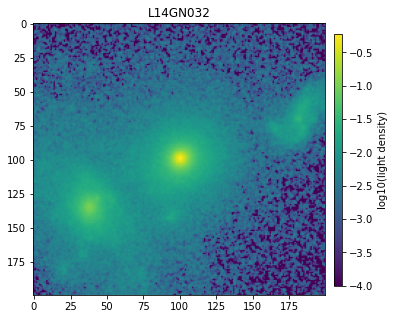

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

gnames=['XI53', 'XN53', 'XG53', 'L14EG010', 'L14EG015', 'L14GN007', 'L14GN032' ]


data = data_reading(image_files[a])
im = ax.imshow(data, aspect = 'auto')
ax.set_title(r'%s' %gnames[a])
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='log10(light density)')

#plt.savefig('HST_data2.png', dpi=100)

In [7]:
def renorm(image):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    
    #ax[0] = plt.subplot2grid((1, 2), (0, 0), colspan=1)
    ax[0].set_title("HST data", size=12)
    im = ax[0].imshow(image)

    if image.shape[0] % 100 !=0 :
        xexces = image.shape[0] % 100
        yexces = image.shape[1] % 100
        
        image = image[int(xexces/2):image.shape[0] - int(xexces/2), 
                      int(yexces/2):image.shape[1] - int(yexces/2)]
    
    image = np.mean(np.mean(image.reshape(100, image.shape[0]//100, 100, image.shape[1]//100), axis=-1), axis=-2)
    

    #ax[1] = plt.subplot2grid((1, 2), (0, 1), colspan=1, sharey=ax[0])
    ax[1].set_title("Resized HST data", size=12)
    im = ax[1].imshow(image)
    
    #plt.subplots_adjust(wspace=0)
    fig.colorbar(im, ax=ax, orientation='vertical', label='log10(light density)', shrink=0.8)

    #plt.savefig('images/HST.png',dpi=100)
    
    return image

In [8]:
pixel_deg=8.333333333333334e-06
pixel_sec=pixel_deg*3600. # arcsec

In [9]:
class Model1(tf.keras.Model):

    def __init__(self, dimout):
        super().__init__()
        self.layer1=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')
        #self.dropout1=tf.keras.layers.Dropout(0.25)
        self.layer2=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer3=tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')
        self.layer4=tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')
        self.layer5=tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same')

        self.flatten=tf.keras.layers.Flatten()
        self.dense1=tf.keras.layers.Dense(1024,activation='relu')
        self.dense2=tf.keras.layers.Dense(512,activation='relu')
        self.dense3=tf.keras.layers.Dense(dimout)
        print(f"Dim out = {dimout}")

        self.max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))


    @tf.function
    def call(self,X,training=True):

        out=self.layer1(X)
        #out=self.dropout1(out, training)
        out=self.max_pool(out)
        out=self.layer2(out)
        out=self.max_pool(out)
        out=self.layer3(out)
        out=self.max_pool(out)
        out=self.layer4(out)
        out=self.max_pool(out)
        out=self.layer5(out)
        out=self.max_pool(out)

        out=self.flatten(out)

        out=self.dense1(out)
        out=self.dense2(out)
        
        return self.dense3(out)


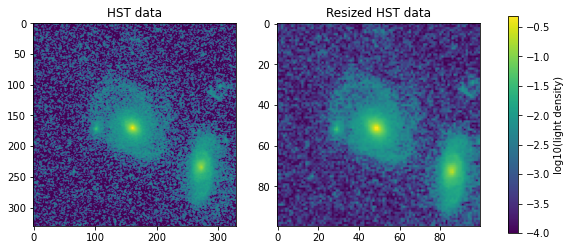

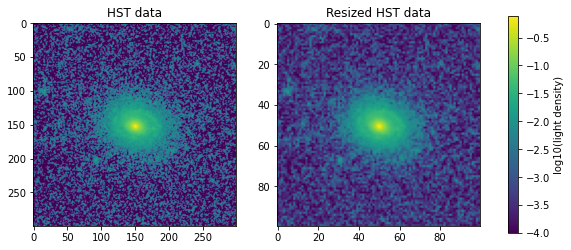

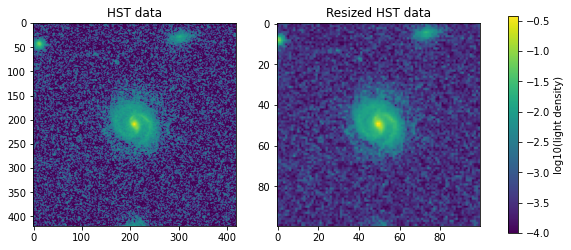

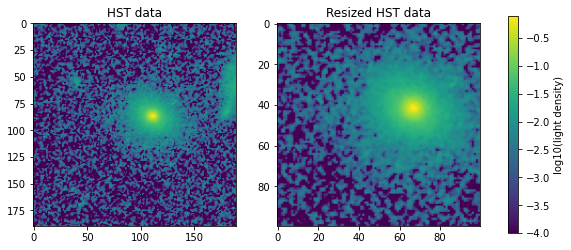

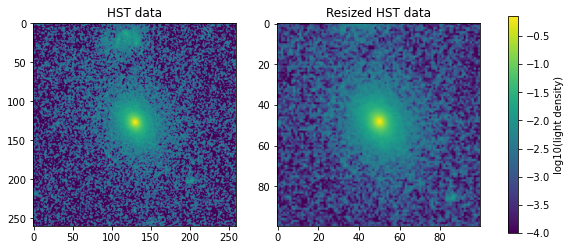

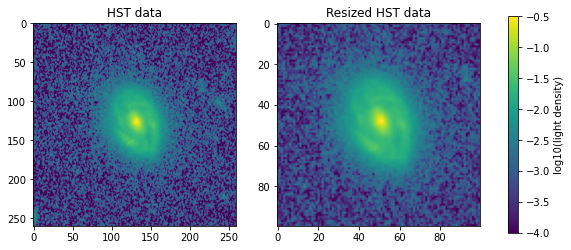

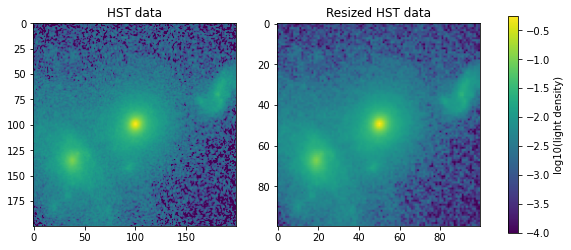

In [10]:
X_test = np.zeros((len(image_files), 100, 100))

for im in range(len(image_files)) :
    data = data_reading(image_files[im])
    X_test[im] = renorm(data)
    #plt.savefig('3Dshapes_PHIBSS2/img%s.png'%im, dpi=100)

In [25]:
# Create a new model instance
model1 = Model1(1)

# Restore the weights
model1.load_weights('./checkpoints/my_checkpoint100')
model1.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

# Evaluate the model
#loss, acc = model1.evaluate(X_train, Y_train_n, verbose=2)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Dim out = 1


2023-01-24 15:55:15.580951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
X_test=X_test.reshape(7,100,100,1)
Y_pred_n = model1(X_test)
Y_pred_n.shape

TensorShape([7, 1])

In [27]:
# Create a new model instance
modelR = Model1(1)

# Restore the weights
modelR.load_weights('./checkpoints/my_checkpoint_R')
modelR.compile(
    optimizer=tf.optimizers.Adam(1e-3),
    loss = tf.keras.losses.MeanSquaredError(),
    metrics = ['accuracy'] )

Dim out = 1


In [28]:
Y_pred_R = modelR(X_test)
Y_pred_R.shape

TensorShape([7, 1])

In [29]:
Y_pred_n = np.array(Y_pred_n)
Y_pred_R = np.array(Y_pred_R)

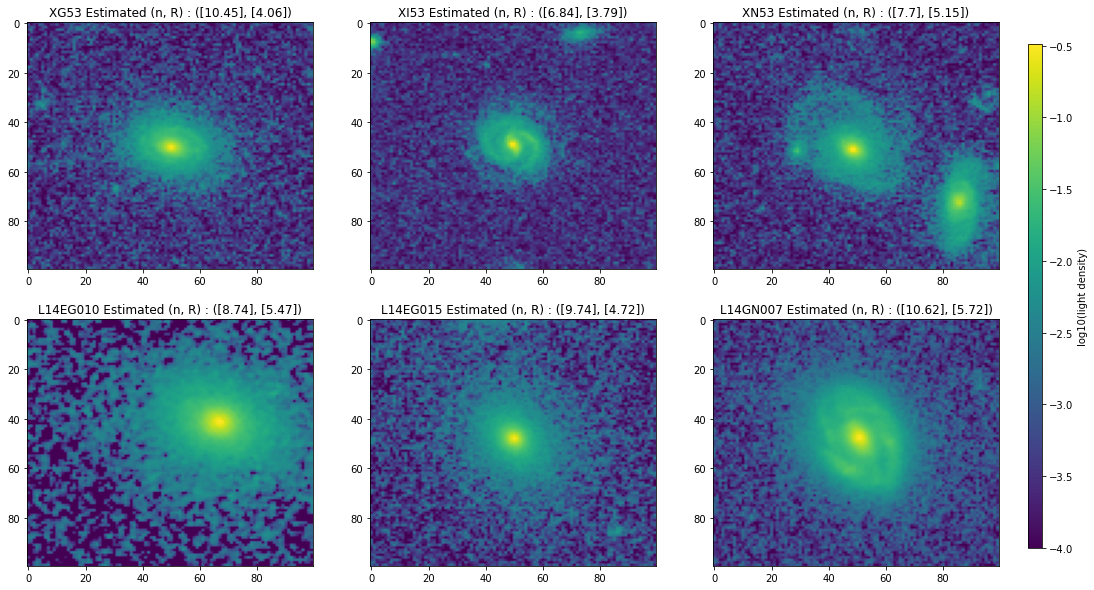

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

a=0
for i in range(2):
    for j in range(3):
        im = ax[i][j].imshow(X_test[a], aspect = 'auto')
        ax[i][j].set_title(r'%s Estimated (n, R) : (%s, %s)' %(gnames[a], Y_pred_n[a]*10, Y_pred_R[a]*4))
        a=a+1
        #plt.colorbar(im, ax=ax[i, j])
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax, label='log10(light density)')

#plt.savefig('3Dshapes_PHIBSS2/predictions_HST.png', dpi=100)

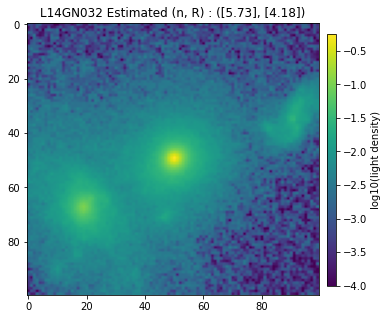

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

im = ax.imshow(X_test[a], aspect = 'auto')
ax.set_title(r'%s Estimated (n, R) : (%s, %s)' %(gnames[a], Y_pred_n[a]*10, Y_pred_R[a]*4))
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='log10(light density)')

#plt.savefig('3Dshapes_PHIBSS2/predictions_HST2.png', dpi=100)

In [35]:
catalog='../Data/ImageCat.txt'
filename=np.genfromtxt(catalog,skip_header=1,dtype='U60',usecols=0)
data=np.genfromtxt(catalog,skip_header =1, usecols=[1,2,3,4,5,6,7]) 

In [36]:
logM = np.copy(data[:,0])
R    = np.copy(data[:,1])
n    = np.copy(data[:,2])
q    = np.copy(data[:,3])
p    = np.copy(data[:,4])
phi  = np.copy(data[:,5])
theta= np.copy(data[:,6])

In [37]:
Y = np.stack([R, n, q, p, phi, theta],axis=1)
Y = Y.astype('float32')


In [38]:
D1 = np.load('../Data/IMAGE/'+ filename[1])['imT']
D1.shape
size = Y.shape[0] 
Y = Y[:size]
D=np.zeros((size,D1.shape[0],D1.shape[0],1)) 
for i in range(size):

    Di=np.load('../Data/IMAGE/'+ filename[i])  
    imTi=np.log10(Di['imT'])
    imTi_min=imTi[imTi>0.].min()
    imTi_max=np.amax(imTi)
    imTi[imTi<0.]=imTi_min
    D[i,:,:,0]=imTi

D = D.astype('float32') 


ngal=np.shape(D)[0]
print("The catalog comprises %i galaxies"%ngal)

The catalog comprises 10120 galaxies


In [42]:
n_pred = [10.45,6.84,7.7,8.74,9.74,10.62,5.73]
R_pred = [4.06,3.79,5.15,5.47,4.72,5.72,4.18]

In [93]:
np.where((Y[:,1]>9.8) & (Y[:,1]<10.6) & (Y[:,0]>3) & (Y[:,0]<6))

(array([10058, 10103]),)

[3.09 9.88 0.1  0.18 0.2  0.14]


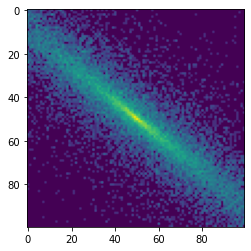

In [96]:
i=10058
print(Y[i,:])
plt.imshow(D[i,:,:,0]) 
plt.show()

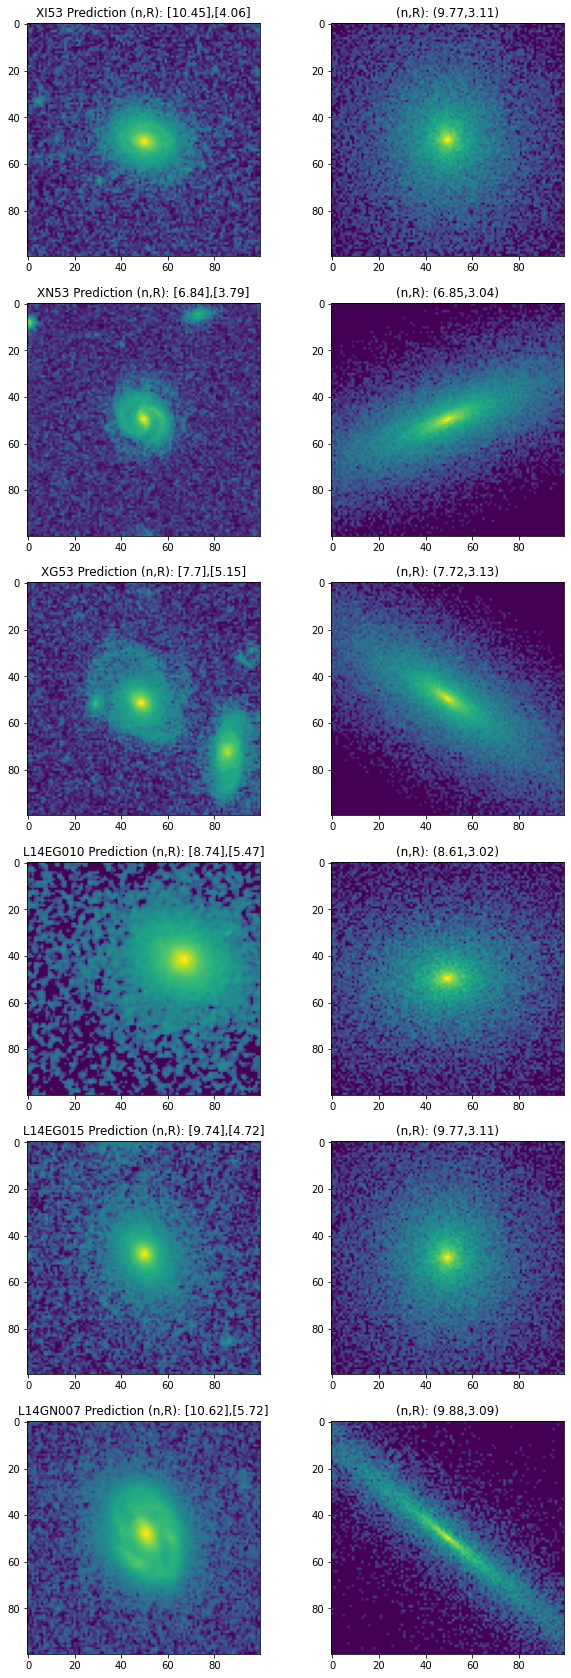

In [42]:
fig, ax = plt.subplots(6, 2, figsize=(10, 30))

i=10075
j=0
ax[j][0].imshow(X_test[j])
ax[j][0].set_title('%s Prediction (n,R): %s,%s'%(gnames[j], Y_pred_n[j]*10, Y_pred_R[j]*4))
ax[j][1].imshow(D[i,:,:,0]) 
ax[j][1].set_title('(n,R): (%s,%s)'%(Y[i,1], Y[i,0]))
        
i=10019
j=1
ax[j][0].imshow(X_test[j])
ax[j][0].set_title('%s Prediction (n,R): %s,%s'%(gnames[j], Y_pred_n[j]*10, Y_pred_R[j]*4))
ax[j][1].imshow(D[i,:,:,0]) 
ax[j][1].set_title('(n,R): (%s,%s)'%(Y[i,1], Y[i,0]))

i=10091
j=2
ax[j][0].imshow(X_test[j])
ax[j][0].set_title('%s Prediction (n,R): %s,%s'%(gnames[j], Y_pred_n[j]*10, Y_pred_R[j]*4))
ax[j][1].imshow(D[i,:,:,0]) 
ax[j][1].set_title('(n,R): (%s,%s)'%(Y[i,1], Y[i,0]))

i=10003
j=3
ax[j][0].imshow(X_test[j])
ax[j][0].set_title('%s Prediction (n,R): %s,%s'%(gnames[j], Y_pred_n[j]*10, Y_pred_R[j]*4))
ax[j][1].imshow(D[i,:,:,0]) 
ax[j][1].set_title('(n,R): (%s,%s)'%(Y[i,1], Y[i,0]))

i=10075
j=4
ax[j][0].imshow(X_test[j])
ax[j][0].set_title('%s Prediction (n,R): %s,%s'%(gnames[j], Y_pred_n[j]*10, Y_pred_R[j]*4))
ax[j][1].imshow(D[i,:,:,0]) 
ax[j][1].set_title('(n,R): (%s,%s)'%(Y[i,1], Y[i,0]))

i=10058
j=5
ax[j][0].imshow(X_test[j])
ax[j][0].set_title('%s Prediction (n,R): %s,%s'%(gnames[j], Y_pred_n[j]*10, Y_pred_R[j]*4))
ax[j][1].imshow(D[i,:,:,0]) 
ax[j][1].set_title('(n,R): (%s,%s)'%(Y[i,1], Y[i,0]))


#plt.savefig('comp_HST_training_set.png', dpi=100)